# Configs

In [0]:
# config for databricks
config = """url: https://cds.climate.copernicus.eu/api
key: 57aa0c72-c6ca-4e40-b4f8-414c6a240523
"""

# Save it to the cluster's root home directory
dbutils.fs.put("file:/root/.cdsapirc", config, overwrite=True)

In [2]:
import os
from datetime import date
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import torch
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
from ecmwf.opendata import Client

load_dotenv()

ecmwf_api_key = os.getenv("ECMWF_API_KEY")

In [2]:
# config for local computer
import os

config = f"""url: https://cds.climate.copernicus.eu/api
key: {ecmwf_api_key}
"""

home = os.path.expanduser("~")
config_path = os.path.join(home, ".cdsapirc")

with open(config_path, "w") as f:
    f.write(config)

print(f"Config written to {config_path}")

Config written to /Users/williamli/.cdsapirc


# Training Data

## Predictors

In [3]:

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure"
    ],
    "year": ["2022", "2023", "2024"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [66, -101, 59, -82]
}

client = cdsapi.Client()
output_path = "train.grib"  # Change to your preferred file name
client.retrieve(dataset, request).download(output_path)


2026-01-04 16:19:31,968 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2026-01-04 16:19:32,585 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
2026-01-04 16:19:32,586 INFO Request ID is 1f623076-915a-44bb-8658-0769a72c0bba
2026-01-04 16:19:32,751 INFO status has been updated to accepted
2026-01-04 16:19:46,872 INFO status has been updated to successful


'train.grib'

In [5]:
grib_path = "train.grib"
ds_train = xr.open_dataset(grib_path, engine='cfgrib')

In [19]:
ds_train

<xarray.Dataset> Size: 940MB
Dimensions:     (time: 26304, latitude: 29, longitude: 77)
Coordinates:
  * time        (time) datetime64[ns] 210kB 2022-01-01 ... 2024-12-31T23:00:00
  * latitude    (latitude) float64 232B 66.0 65.75 65.5 ... 59.5 59.25 59.0
  * longitude   (longitude) float64 616B -101.0 -100.8 -100.5 ... -82.25 -82.0
    number      int64 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    valid_time  (time) datetime64[ns] 210kB ...
Data variables:
    u10         (time, latitude, longitude) float32 235MB 1.481 1.459 ... -2.618
    v10         (time, latitude, longitude) float32 235MB -6.937 ... -13.77
    t2m         (time, latitude, longitude) float32 235MB 249.9 249.9 ... 270.9
    msl         (time, latitude, longitude) float32 235MB 1.013e+05 ... 9.912...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-04T16:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
client = Client(source="ecmwf", model="ifs", resol="0p25")

# Download to a file
grib_path = "realtime_forecast.grib2"
client.retrieve(
    date=date.today(),
    time=0,
    type="fc",
    step=[0],
    param=["10u","10v","2t","msl"],
    target=grib_path,
)

To ensure the stability of our systems and to preserve resources for our operational activities (network, compute, etc.), access to the open-data portal is limited to 500 simultaneous connections. This limit helps us guarantee reliable service for our operational users, especially during periods of high demand. For added reliability, the open-data is replicated across AWS, Azure, and Google Cloud. If you experience difficulties accessing the portal directly, you can also retrieve the data from these cloud platforms.
                                                                                     

By downloading data from the ECMWF open data dataset, you agree to the terms: Attribution 4.0 International (CC BY 4.0). Please attribute ECMWF when downloading this data.


In [4]:
# read the GRIB file

grib_path = "realtime_forecast.grib2"

ds_forecast = xr.open_dataset(grib_path, engine='cfgrib')


skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/Users/williamli/Code/cyrt-safe-to-land/.venv/lib/python3.14/site-packages/cfgrib/dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/williamli/Code/cyrt-safe-to-land/.venv/lib/python3.14/site-packages/cfgrib/dataset.py", line 642, in dict_merge
    raise DatasetBuildError(
    ...<2 lines>...
    )
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(10.0)) new_value=Variable(dimensions=(), data=np.float64(2.0))


# Reponse Variable

In [30]:
import requests
from datetime import datetime, timedelta

api_key = os.getenv('METAR_TAF_API_KEY')
url = "https://api.metar-taf.com/metar-archive"
station_id = "CYRT"

start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 12, 31)

all_metars = []

date = start_date
while date <= end_date:
    params = {
        "api_key": api_key,
        "v": "2.3",
        "locale": "en-US",
        "id": station_id,
        "date": date.strftime("%Y-%m-%d")
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        all_metars.extend(data.get("metars", []))
    else:
        print(f"Failed for {date.strftime('%Y-%m-%d')}")
    date += timedelta(days=1)

# Now all_metars contains all METARs for 2023
print(f"Total METARs collected: {len(all_metars)}")

Total METARs collected: 32529


In [31]:
# --- Define rule thresholds ---
VIS_MIN_M = 1600
CEILING_MIN_FT = 500
DISALLOW_WEATHER = {"FZFG", "FC", "SQ", "+TS", "TS+", "TS", "ICE", "IC", "FZRA"}

def check_ok_to_land(m):
    # Visibility check
    vis_ok = (m.get("visibility") or 0) >= VIS_MIN_M
    # Ceiling check
    ceil_ft = m.get("ceiling")
    ceil_ok = (ceil_ft is None) or (ceil_ft >= CEILING_MIN_FT)
    # Weather check: look for disallowed tokens in raw METAR
    raw = m.get("raw", "").upper()
    weather_ok = not any(token in raw for token in DISALLOW_WEATHER)
    # Final decision
    return int(vis_ok and ceil_ok and weather_ok)

# --- Build DataFrame ---
rows = []
for metar in data["metars"]:
    ok_flag = check_ok_to_land(metar)
    dt = datetime.utcfromtimestamp(metar["observed"])
    rows.append({
        "datetime": dt,
        "ok_to_land": ok_flag
    })

df = pd.DataFrame(rows)
print(df)


              datetime  ok_to_land
0  2024-12-31 00:00:00           1
1  2024-12-31 01:00:00           1
2  2024-12-31 02:00:00           1
3  2024-12-31 03:00:00           1
4  2024-12-31 04:00:00           1
5  2024-12-31 05:00:00           1
6  2024-12-31 06:00:00           1
7  2024-12-31 07:00:00           1
8  2024-12-31 08:00:00           1
9  2024-12-31 09:00:00           1
10 2024-12-31 10:00:00           1
11 2024-12-31 10:32:00           1
12 2024-12-31 11:00:00           1
13 2024-12-31 12:00:00           1
14 2024-12-31 13:00:00           1
15 2024-12-31 14:00:00           1
16 2024-12-31 15:00:00           1
17 2024-12-31 15:13:00           1
18 2024-12-31 15:27:00           1
19 2024-12-31 15:31:00           1
20 2024-12-31 16:00:00           1
21 2024-12-31 17:00:00           1
22 2024-12-31 18:00:00           1
23 2024-12-31 18:27:00           1
24 2024-12-31 19:00:00           1
25 2024-12-31 20:00:00           1
26 2024-12-31 21:00:00           1
27 2024-12-31 22:00:

/var/folders/y4/740q3p1n6c93w54lzgzdsrsh0000gn/T/ipykernel_46292/646112923.py:22: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(metar["observed"])


In [32]:
# Build a list with time and response variable for each METAR
results = []
for metar in all_metars:
    ok_flag = check_ok_to_land(metar)
    dt = datetime.utcfromtimestamp(metar.get("observed"))
    results.append({"datetime": dt, "ok_to_land": ok_flag})

# Print first 10 rows as a sample
for row in results[:10]:
    print(row)

ok_to_land_df = pd.DataFrame(results)

ok_to_land_df['ok_to_land'].value_counts()

{'datetime': datetime.datetime(2022, 1, 1, 0, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 1, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 2, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 3, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 4, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 5, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 6, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 7, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 8, 0), 'ok_to_land': 1}
{'datetime': datetime.datetime(2022, 1, 1, 9, 0), 'ok_to_land': 1}


/var/folders/y4/740q3p1n6c93w54lzgzdsrsh0000gn/T/ipykernel_46292/480687095.py:5: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(metar.get("observed"))


ok_to_land
1    22191
0    10338
Name: count, dtype: int64

In [33]:
# Keep only rows where the time is exactly on the hour
on_the_hour_df = ok_to_land_df[ok_to_land_df['datetime'].dt.minute == 0].copy()
on_the_hour_df.reset_index(drop=True, inplace=True)
on_the_hour_df

,datetime,ok_to_land
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,1
2,2022-01-01 02:00:00,1
3,2022-01-01 03:00:00,1
4,2022-01-01 04:00:00,1
...,...,...
25813,2024-12-31 19:00:00,1
25814,2024-12-31 20:00:00,1
25815,2024-12-31 21:00:00,1
25816,2024-12-31 22:00:00,1


In [34]:
# Find which hourly timestamps are missing from the filtered DataFrame for 2023
import pandas as pd
from datetime import datetime, timedelta

# Generate all expected hourly timestamps for 2022-2024
start = datetime(2022, 1, 1, 0, 0)
end = datetime(2024, 12, 31, 23, 0)
expected_hours = pd.date_range(start, end, freq='H')

# Find missing timestamps
actual_hours = pd.to_datetime(on_the_hour_df['datetime'])
missing_hours = expected_hours.difference(actual_hours)

print(f"Number of missing hours: {len(missing_hours)}")
# print("Missing hourly timestamps:")
# for ts in missing_hours:
#     print(ts)

Number of missing hours: 486


/var/folders/y4/740q3p1n6c93w54lzgzdsrsh0000gn/T/ipykernel_46292/1359584380.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start, end, freq='H')


In [35]:
# Fill missing hourly timestamps with the most recent past value for ok_to_land
filled_df = on_the_hour_df.set_index('datetime').reindex(expected_hours)
filled_df['ok_to_land'] = filled_df['ok_to_land'].ffill()
filled_df.reset_index(inplace=True)
filled_df.rename(columns={'index': 'datetime'}, inplace=True)
print(f"Rows after filling: {len(filled_df)}")
filled_df

Rows after filling: 26304


,datetime,ok_to_land
0,2022-01-01 00:00:00,1.0
1,2022-01-01 01:00:00,1.0
2,2022-01-01 02:00:00,1.0
3,2022-01-01 03:00:00,1.0
4,2022-01-01 04:00:00,1.0
...,...,...
26299,2024-12-31 19:00:00,1.0
26300,2024-12-31 20:00:00,1.0
26301,2024-12-31 21:00:00,1.0
26302,2024-12-31 22:00:00,1.0


In [36]:
# save filled_df to csv
filled_df.to_csv("response_variable_historical.csv", index=False)

# load filled_df from csv
filled_df = pd.read_csv("response_variable_historical.csv")


In [3]:
# load filled_df from csv
filled_df = pd.read_csv("response_variable_historical.csv")

In [37]:
filled_df['ok_to_land'].value_counts()

ok_to_land
1.0    18729
0.0     7575
Name: count, dtype: int64

## Create Tensors

In [38]:
variables = ['t2m', 'u10', 'v10', 'msl']  # adjust to match your dataset
X = np.stack([ds_train[var].values for var in variables], axis=1)  # shape: (time, channel, lat, lon)

# 2. Get response variable for each hour (make sure times align!)
y = filled_df['ok_to_land'].values  # shape: (time,)

# add a time lag so we are predicting into the future
lag = 6
X = X[:-lag]  # remove last 'lag' time steps
y = y[lag:]   # shift labels accordingly

# 3. Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # or torch.long for classification


# Modeling

In [39]:
import numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

X_all = np.stack([ds_train[var].values for var in variables], axis=1)  # shape: (N, C, H, W)y_all = filled_df['ok_to_land'].values  # shape: (time,)
y_all = filled_df['ok_to_land'].values  # shape: (N,)

lag = 6
# lag the values
X_all = X_all[:-lag]  # remove last 'lag' time steps
y_all = y_all[lag:]   # shift labels accordingly

# ---------- Dataset ----------
class Snapshots(Dataset):
    def __init__(self, X, y):
        self.X = X.astype("float32")
        self.y = y.astype("float32")
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i])

# ---------- Model ----------
class WeatherLanding2DNet(nn.Module):
    def __init__(self, in_ch, base=16):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base, base, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(base*2, 1)  # logit
        )
    def forward(self, x):  # x: (B, C, H, W)
        z = self.features(x)
        return self.head(z).squeeze(1)  # (B,)

# ---------- Prep splits & normalization ----------
# Assume X_all: (N, C, H, W), y_all: (N,)
N = len(y_all)
N_tr, N_val = int(0.33*N), int(0.33*N)
# (If data has time order, split by time: early->train, later->val/test)

# Per-channel normalize using TRAIN ONLY (avoid leakage)
mu = X_all[:N_tr].mean(axis=(0,2,3), keepdims=True)
sd = X_all[:N_tr].std(axis=(0,2,3), keepdims=True) + 1e-6
Xn = (X_all - mu) / sd

tr_ds  = Snapshots(Xn[:N_tr], y_all[:N_tr])
val_ds = Snapshots(Xn[N_tr:N_tr+N_val], y_all[N_tr:N_tr+N_val])
te_ds  = Snapshots(Xn[N_tr+N_val:], y_all[N_tr+N_val:])

tr_dl  = DataLoader(tr_ds, batch_size=16, shuffle=True,  drop_last=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
te_dl  = DataLoader(te_ds, batch_size=16, shuffle=False)

# ---------- Train ----------
device = "cpu"
model = WeatherLanding2DNet(in_ch=Xn.shape[1], base=16).to(device)
pos_rate = y_all[:N_tr].mean()
pos_weight = torch.tensor([(1-pos_rate)/max(pos_rate,1e-6)]) if 0<pos_rate<1 else None

crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt  = torch.optim.AdamW(model.parameters(), lr=3e-4)

def run_epoch(dl, train=True):
    model.train(train)
    total, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logit = model(xb)
            loss  = crit(logit, yb)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()*xb.size(0); n += xb.size(0)
    return total/n

best, best_state = 1e9, None
for ep in range(1, 11):  # ~10 epochs to start
    tr = run_epoch(tr_dl, True)
    va = run_epoch(val_dl, False)
    if va < best: best, best_state = va, {k:v.cpu().clone() for k,v in model.state_dict().items()}
    print(f"epoch {ep:02d} | train {tr:.4f} | val {va:.4f}")
model.load_state_dict(best_state)

# ---------- Evaluate on test & get probabilities ----------
import math
model.eval()
probs, labels = [], []
with torch.no_grad():
    for xb, yb in te_dl:
        xb = xb.to(device)
        logit = model(xb)
        p = torch.sigmoid(logit)              # prob of class 1 (allowed)
        probs.append(p.cpu()); labels.append(yb)
probs  = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()

# Choose a decision threshold on VALIDATION, then apply to TEST
# Example: 0.5 threshold (replace with your tuned value)
pred = (probs >= 0.6).astype(int)

# Simple metrics
acc = (pred == labels).mean()
print("Test accuracy:", acc)

epoch 01 | train 0.2579 | val 0.2760
epoch 02 | train 0.2289 | val 0.2652
epoch 03 | train 0.2220 | val 0.2782
epoch 04 | train 0.2167 | val 0.2726
epoch 05 | train 0.2112 | val 0.3511
epoch 06 | train 0.2088 | val 0.2798
epoch 07 | train 0.2048 | val 0.3426
epoch 08 | train 0.2031 | val 0.3254
epoch 09 | train 0.1985 | val 0.3540
epoch 10 | train 0.1967 | val 0.2944
Test accuracy: 0.7683963319167971


In [40]:
model.eval()
probs, labels = [], []
with torch.no_grad():
    for xb, yb in te_dl:
        xb = xb.to(device)
        logit = model(xb)
        p = torch.sigmoid(logit)              # prob of class 1 (allowed)
        probs.append(p.cpu()); labels.append(yb)
probs  = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()

# Choose a decision threshold on VALIDATION, then apply to TEST
# Example: 0.5 threshold (replace with your tuned value)
pred = (probs >= 0.5).astype(int)

# Simple metrics
acc = (pred == labels).mean()
print("Test accuracy:", acc)

Test accuracy: 0.7974726012077835


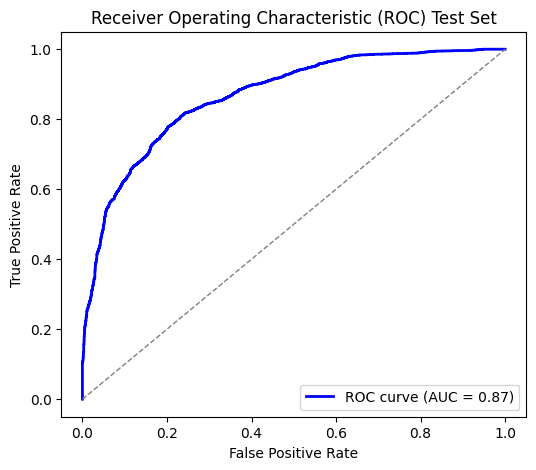

In [42]:
# Plot ROC curve for test set
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Test Set')
plt.legend(loc="lower right")
plt.show()
    

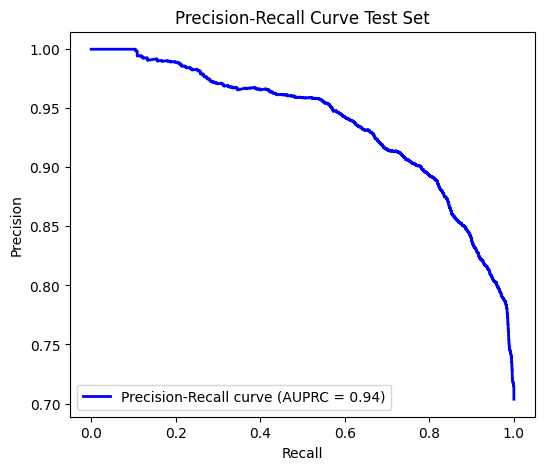

In [43]:
# make a AUPRC curve
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(labels, probs)
auprc = auc(recall, precision)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Test Set')
plt.legend(loc="lower left")
plt.show()  

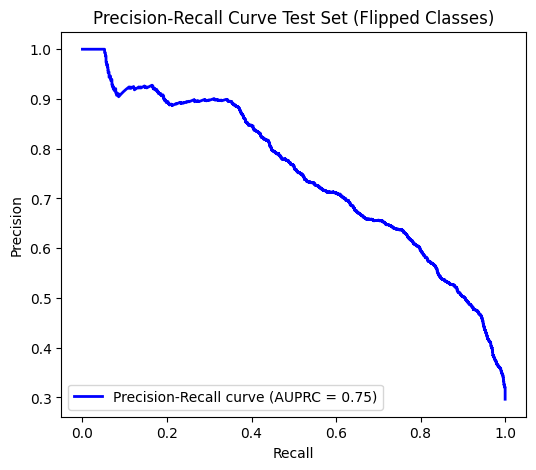

In [45]:
# AUPRC but flip the classes
precision, recall, thresholds = precision_recall_curve(1-labels, 1-probs)
auprc = auc(recall, precision)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Test Set (Flipped Classes)')
plt.legend(loc="lower left")
plt.show()

In [44]:
# the breakdown of the response by percent true and false by month

# Assuming you have a DataFrame `filled_df` with a 'date' column and 'ok_to_land' column
filled_df['datetime'] = pd.to_datetime(filled_df['datetime'])
filled_df['month'] = filled_df['datetime'].dt.to_period('M')

# Calculate the percentage of true/false responses by month
monthly_breakdown = filled_df.groupby('month')['ok_to_land'].value_counts(normalize=True).unstack(fill_value=0)
monthly_breakdown = monthly_breakdown.rename(columns={0: 'percent_false', 1: 'percent_true'})       

# Display the monthly breakdown
print(monthly_breakdown)


ok_to_land  percent_false  percent_true
month                                  
2022-01          0.673387      0.326613
2022-02          0.763393      0.236607
2022-03          0.466398      0.533602
2022-04          0.166667      0.833333
2022-05          0.084677      0.915323
2022-06          0.036111      0.963889
2022-07          0.028226      0.971774
2022-08          0.018817      0.981183
2022-09          0.137500      0.862500
2022-10          0.103495      0.896505
2022-11          0.516667      0.483333
2022-12          0.442204      0.557796
2023-01          0.553763      0.446237
2023-02          0.797619      0.202381
2023-03          0.739247      0.260753
2023-04          0.312500      0.687500
2023-05          0.075269      0.924731
2023-06          0.108333      0.891667
2023-07          0.029570      0.970430
2023-08          0.013441      0.986559
2023-09          0.131944      0.868056
2023-10          0.068548      0.931452
2023-11          0.268056      0.731944
